In [16]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=2)
import scipy.optimize as optimize

# Define goal

Our goal will be denoted as $g$, for now we simply assume its defined in the full state space

In [17]:
g = np.array([5, 0, 6, 0, 7, 0])

# Collect Initial Data

Let's pretend our data comes from pulling a 2-link object to the right for 6 time steps

In [202]:
training_data = []
for _ in range(100):
    y = np.random.randint(-10,10)
    i = np.random.randint(-5,5)
    training_data.append((np.array([[i],[y],[i+1],[y],[i+2],[y]]),
         np.array([[1],[0]]),
         np.array([[i+1],[y],[i+2],[y],[i+3],[y]]),
         np.array([[g[0] - i]]),
         np.array([[g[0] - i+1]])))

# Optimize Simple Models

We assume linear forms for all our functions:
$
\begin{align}
f(s_t) &= As_t \\
f(s_t) &= Bo + Cu \\
\hat{c}(s_t) &= (\text{goal} - s_t)^TD(\text{goal} - s_t) \\
\end{align}
$

In [318]:
def params_to_matrices(params):
    a1 = params[0]
    a2 = params[1]
    a3 = params[2]
    a4 = params[3]
    a5 = params[4]
    a6 = params[5]
    b = params[6]
    c1 = params[7]
    c2 = params[8]
    d = params[9]

    A = np.array([[a1, a2, a3, a4, a5, a6]])
    B = np.array([[b]])
    C = np.array([[c1, c2]])
    D = np.array([[d]])
    return A, B, C, D

def objective(params, data, alpha):
    """ return: MSE over all training examples """
    A, B, C, D = params_to_matrices(params)

    err = np.zeros(len(data))
    for i, (s, u, s_, c, c_) in enumerate(data):
        err[i] = alpha*np.linalg.norm(A@s + (B@A@s + C@u) - A@s_) + (1-alpha)*abs(D*np.linalg.norm(A@g-A@s) - c)

    obj = (err**2).mean()
    return obj

def train(training_data, alpha=0.5):
    """
    param training_data: a list of tuples ([6x1], [2x1], [6x1], [1x1])
    """
        
    def __objective(params):
        return objective(params, training_data, alpha)
    
    for i in range(10):
        result = optimize.minimize(__objective, np.random.randn(10), method='Nelder-Mead')
        if result.success:
            break
    
    if not result.success:
        print("Status: {:d}, Message: {:s}".format(result.status, result.message))
        return None
    
    return result.x

In [322]:
params = train(training_data, alpha=0.5)
A, B, C, D = params_to_matrices(params)
print(A)
print(B)
print(C)
print(D)

[[ 2.22 -0.11 -0.31  0.05 -1.67  0.07]]
[[0.25]]
[[ 1.23 -1.71]]
[[4.04]]


# Check if the matrices we solved for successfully minimize the error

What is the predicted cost of the plan $[[1,0], \dots]$

In [323]:
actions = [np.array([[1],[0]]), np.array([[1],[0]]),np.array([[1],[0]]),np.array([[1],[0]]),np.array([[1],[0]])]
s0 = np.array([[0], [0], [1], [0], [2], [0]])
o = A@s0
for i, u in enumerate(actions):
    o_ += B@o + C@u
    c_hat = D@o
    print(o, c_hat)
    o = o_

[[-3.64]] [[-14.73]]
[[26.99]] [[109.08]]
[[35.08]] [[141.78]]
[[45.22]] [[182.77]]
[[57.94]] [[234.19]]


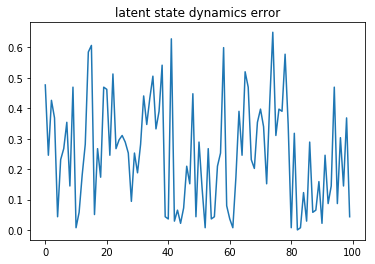

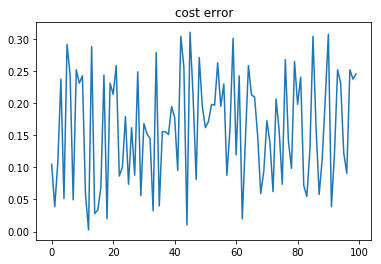

In [324]:
predicted_latent_state_dynamics_error = []
predicted_cost = []
for i, (s, u, s_, c, c_) in enumerate(training_data):
    
    yy = np.linalg.norm(A@s + (B@A@s + C@u) - A@s_)
    xx = abs(D*np.linalg.norm(A@g-A@s) - c)

    predicted_latent_state_dynamics_error.append(np.squeeze(xx))
    predicted_cost.append(np.squeeze(yy))

plt.figure()
plt.plot(predicted_latent_state_dynamics_error, label='dynamics error in latent space')
plt.title("latent state dynamics error")
plt.gca().ticklabel_format(useOffset=False)

plt.figure()
plt.plot(predicted_cost)
plt.gca().ticklabel_format(useOffset=False)
plt.title("cost error");

If we call optimize with $\alpha=0.5$, we say it doest a pretty ok job at meeting both components of the objective. However, the scale of our cost should probably be normalized, or we should weight how much we care about cost versus prediction accuracy. What is the trade-off hear? Which do we care more about? Is there a theoretical answer here?

To double check my objective function, let's make sure that my hand-designed model reductions give zero in the objective function:

In [325]:
my_params = np.array([1, 0, 0, 0, 0, 0, 0, 1, 0, 1])
print(objective(my_params, data=training_data, alpha=0.5))

0.0


Ok so the objective function is zero for my hand-specified paramters which suggests that it is correct. Butyet my numerical methods are not finding this.

# What if we only consider cost, and predicting cost?

In [329]:
def objective(params, data, alpha):
    """ return: MSE over all training examples """
    A, B, C, D = params_to_matrices(params)

    err = np.zeros(len(data))
    for i, (s, u, s_, c, c_) in enumerate(data):
        err[i] = alpha*np.linalg.norm(D*np.linalg.norm(A@s + (B@A@s + C@u) - D@A@s_) + (1-alpha)*abs(D*np.linalg.norm(A@g-A@s) - c)

    obj = (err**2).mean()
    return obj

def train(training_data, alpha=0.5):
    """
    param training_data: a list of tuples ([6x1], [2x1], [6x1], [1x1])
    """
        
    def __objective(params):
        return alt_objective(params, training_data, alpha)
    
    for i in range(10):
        result = optimize.minimize(__objective, np.random.randn(10), method='Nelder-Mead')
        if result.success:
            break
    
    if not result.success:
        print("Status: {:d}, Message: {:s}".format(result.status, result.message))
        return None
    
    return result.x

SyntaxError: invalid syntax (<ipython-input-329-d3b8998af493>, line 9)

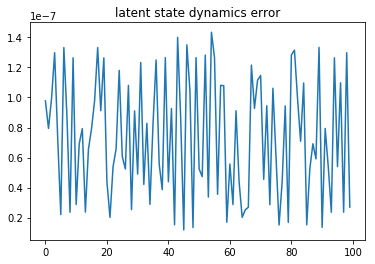

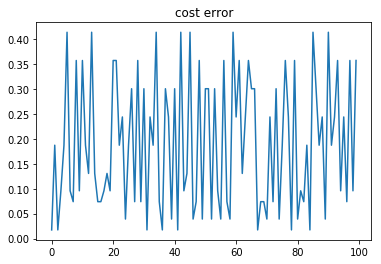

In [328]:
predicted_latent_state_dynamics_error = []
predicted_cost = []
for i, (s, u, s_, c, c_) in enumerate(training_data):
    
    yy = np.linalg.norm(A@s + (B@A@s + C@u) - A@s_)
    xx = abs(D*np.linalg.norm(A@g-A@s) - c)

    predicted_latent_state_dynamics_error.append(np.squeeze(xx))
    predicted_cost.append(np.squeeze(yy))

plt.figure()
plt.plot(predicted_latent_state_dynamics_error, label='dynamics error in latent space')
plt.title("latent state dynamics error")
plt.gca().ticklabel_format(useOffset=False)

plt.figure()
plt.plot(predicted_cost)
plt.gca().ticklabel_format(useOffset=False)
plt.title("cost error");